<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQfPBCGLDxsK-f0Wnhf9jOj4HnYDCAA8QFvPw&s" width="200">

# 01MIAR - Actividad Dataset

Esta actividad tiene el objetivo de aplicar los conocimientos adquiridos en el curso sobre tratamiento, análisis y visualización de datos con Python.

In [19]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import textdistance

# 1. Conjunto de datos

El dataset elegido para esta actividad contiene datos sobre más de 300.000 accidentes de tráfico en Reino Unido entre los años 2021 y 2022. Este conjunto de datos contiene información muy valiosa sobre la seguridad vial, pero a partir de ellos no vamos a poder extraer algunas conclusiones que serían muy valiosas como, por ejemplo, los factores de riesgo que pueden provocar un accidente. Entre estos factores podríamos intentar valorar las condiciones climáticas, la ubicación geográfica o el tipo de vehículo. Sin embargo, este dataset solo contiene observaciones de accidentes, por lo que no disponemos de un contrafactual para comparar con situaciones que no hayan llevado a un accidente. Para estimar los factores de riesgo en el caso de las condiciones climáticas, por ejemplo, necesitaríamos conocer todos los desplazamientos realizados en Reino Unido entre esos años, y las condiciones climáticas en cada uno, lo que nos proporcionaría una estimación válida de si una condición climática concreta provoca realmente accidentes o no. 

Este cuaderno está organizado de la siguiente manera: la Seccion 1 proporciona una introducción al trabajo, explicando los análisis que se harán, y presentando, leyendo y describiendo el contenido del conjunto de datos. La Sección 2 está dedicada a la limpieza y preprocesamiento del dataset, que pretende facilitar las tareas posteriores de análisis, con transformaciones de variables existentes o creación de nuevas, y tratando datos erróneos y faltantes. La Sección 3 presenta un análisis descriptivo y exploratorio del conjunto de datos, visualizando las variables más importantes y sus relaciones. La Sección 4 presenta un análisis estadístico que estima los factores de riesgo de los accidentes graves en relación con los accidentes leves.La Sección 5 presenta un segundo análisis estadístico que compara el riesgo de accidentes entre regiones geográficas. Por último, la Sección 6 resume las conclusiones de esta actividad.


## 1.1. Fuente

El conjunto de datos elegido para esta actividad proviene de kaggle. El enlace para este dataset es el siguiente: [enlace al dataset road-accidents-dataset en kaggle](https://www.kaggle.com/datasets/atharvasoundankar/road-accidents-dataset). 


## 1.2. Objetivos

Como ya hemos expuesto en la introducción, debido a la naturaleza del conjunto de datos no es posible realizar algunos de los análisis que nos gustaría. Sin embargo, si que podemos realizar otros análisis muy interesantes, como los que describimos a continuación:

1. Estimación de factores de riesgo de accidentes graves en comparación con accidentes leves
2. Comparación del riesgo de accidentes entre regiones (valor estadístico limitado)
    - Asumiremos la hipótesis de que el riesgo base de accidentes es constante, y proporcional a la población de cada región
    - Para este cálculo tenemos que incluir datos de población, que obtendremos de ...
3. Análisis descriptivos sobre accidentes
    - Tendencia en el tiempo
    - Condiciones climáticas más comunes cuando se producen accidentes
    - Lugares más comunes donde se producen accidentes
    - etc

En este cuaderno realizaremos estos análisis, explicando en cada caso los resultados obtenidos y la metodología empleada.


## 1.3. Lectura del conjunto de datos

Leemos los datos con una petición a la API de Kaggle, descomprimimos el fichero recibido, y lo procesamos con pandas. 

In [2]:
# Lectura del dataset

# Petición a kaggle del dataset comprimido
url = "https://www.kaggle.com/api/v1/datasets/download/atharvasoundankar/road-accidents-dataset"
response = requests.get(url)


# Descomprimir y leer con pandas
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("Road Accident Data.csv") as accidents_file:
        accidents = pd.read_csv(accidents_file)

In [3]:
# Mostrar contenido y variables
print(accidents.shape)
print(accidents.columns)
display(accidents.sample(5))

(307973, 21)
Index(['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')


,Accident_Index,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),Carriageway_Hazards,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
280891,BS0280892,29-03-2022,Monday,Give way or uncontrolled,T or staggered junction,Slight,51.344716,Daylight,Thanet,NaN,...,1,2,Kent,Dry,Dual carriageway,30,14:30,Urban,Fine no high winds,Car
200542,BS0200543,09-11-2022,Tuesday,Auto traffic signal,T or staggered junction,Slight,53.450739,Daylight,Trafford,NaN,...,2,2,Greater Manchester,Dry,Single carriageway,30,16:00,Urban,Fine no high winds,Car
79443,BS0079444,23-03-2021,Monday,Data missing or out of range,Not at junction or within 20 metres,Serious,52.996691,Darkness - no lighting,Amber Valley,NaN,...,3,2,Derbyshire,Dry,Single carriageway,60,19:00,Rural,Fine + high winds,Car
213688,BS0213689,16-04-2022,Friday,Authorised person,T or staggered junction,Slight,53.688256,Darkness - lighting unknown,Calderdale,NaN,...,1,1,West Yorkshire,Dry,Single carriageway,30,03:30,Urban,Fine no high winds,Motorcycle over 500cc
4074,BS0004075,22-08-2021,Saturday,Give way or uncontrolled,T or staggered junction,Slight,51.487037,Daylight,Hammersmith and Fulham,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,16:48,Urban,Fine no high winds,Car


## 1.3 Contenido del conjunto de datos

Como hemos podido ver en las salidas del código anteriores, este conjunto de datos tiene 21 columnas y 307.973 filas. En esta subsección vamos a describir el contenido del dataset, observando las propiedades de cada variable. Para ello, las vamos dividir en dos grupos según sean categóricas o numéricas. La mayoría de ellas son categóricas, como se puede ver a continuación:

In [4]:
# Tipos de las variables y su contenido (rango, tipos de valores, NAs)

accidents.info()

# Código personalizado

print(f"\n{'Variable':<27} -> {'dtype':<10} (Comentario)")
for var in accidents.columns:
    dtype = str(accidents[var].dtype)
    
    # Comentario por tipo de variable categóricas / numéricas
    if dtype == "object":
        unique_values = np.unique(accidents[var].dropna())
        comment_on_variable = f"{unique_values.shape[0]:_} valores posibles: {', '.join(unique_values[:2])}, ..."
    else:
        comment_on_variable = f"Rango: [{accidents[var].min()}, {accidents[var].max()}]"

    is_na = accidents[var].isna()
    if any(is_na):        
        comment_on_variable = f"Contiene {is_na.sum():_} NA; " + comment_on_variable

    print(f"{var:<27} -> {dtype:<10} ({comment_on_variable})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              307973 non-null  object 
 1   Accident Date               307973 non-null  object 
 2   Day_of_Week                 307973 non-null  object 
 3   Junction_Control            307973 non-null  object 
 4   Junction_Detail             307973 non-null  object 
 5   Accident_Severity           307973 non-null  object 
 6   Latitude                    307973 non-null  float64
 7   Light_Conditions            307973 non-null  object 
 8   Local_Authority_(District)  307973 non-null  object 
 9   Carriageway_Hazards         5424 non-null    object 
 10  Longitude                   307973 non-null  float64
 11  Number_of_Casualties        307973 non-null  int64  
 12  Number_of_Vehicles          307973 non-null  int64  
 13  Police_Force  

#### Variables categóricas

1. ``Accident_Index``: Código identificativo con 2 letras y 7 números
2. ``Accident Date``: Fecha del accidente en formato día-mes-año.
3. ``Day_of_Week``: Día de la semana del accidente.
4. ``Junction_Control``: Tipo de regulación de la intersección del accidente (si aplica).
5. ``Junction_Detail``: Detalles sobre la intersección del accidente (si aplica).
6. ``Accident_Severity``: Tipo de gravedad del accidente
7. ``Light_Conditions``: Condiciones de luminosidad del accidente.
8. ``Local_Authority_(District)``: Distrito competente en el lugar del accidente.
9. ``Carriageway_Hazards``: Peligros en el lugar del accidente (animales, peatones, otro accidente, etc).
10. ``Police_Force``: Tipo de policía que acude al lugar del accidente.
11. ``Road_Surface_Conditions``: Condiciones de la carretera en el lugar del accidente.
12. ``Road_Type``: Tipo de carretera del lugar del accidente.
13. ``Time``: Hora del accidente.
14. ``Urban_or_Rural_Area``: Zona urbana o rural. 
15. ``Weather_Conditions``: Condiciones climáticas en el lugar del accidente (lluvia, viento, niebla, etc).
16. ``Vehicle_Type``: Tipo de vehículo que provoca el accidente.

<br>

Las variables de fecha y hora tienen que ser transformadas a una variable de tipo timestamp para manejarse mejor. Como la variable con la hora (``Time``) tiene datos faltantes, los rellenaremos por defecto con la hora '00:00', ya que no hay ninguna otra observación con esta hora y podrán seguir siendo identificables en caso de causar problemas.

La otra variable que también tiene NAs es ``Carriageway_Hazards``, para la cual el 98% de los datos son faltantes. Para no asumir ninguna cualidad sobre esta variable, los reemplazaremos por el valor por defecto 'unknown'.

Llama la atención que la variable ``Junction_Control`` tiene como uno de sus valores 'Auto traffic sigl', lo que parece un error. En la siguiente sección lo exploraremos más en detalle, y analizaremos si debe ser corregido.

In [5]:
# Estadísticos descriptivos básicos de las variables categóricas (recuento, valores únicos, moda)
display(accidents.describe(include = [ "O" ]))

,Accident_Index,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Light_Conditions,Local_Authority_(District),Carriageway_Hazards,Police_Force,Road_Surface_Conditions,Road_Type,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
count,307973,307973,307973,307973,307973,307973,307973,307973,5424,307973,307973,307973,307956,307973,307973,307973
unique,307973,730,7,7,9,4,5,422,5,51,5,5,1439,2,8,15
top,BS0307973,13-11-2021,Friday,Give way or uncontrolled,Not at junction or within 20 metres,Slight,Daylight,Birmingham,Other object on road,Metropolitan Police,Dry,Single carriageway,17:00,Urban,Fine no high winds,Car
freq,1,692,50529,150045,123094,263280,227286,6165,2243,46789,208967,230612,2933,198532,244496,239794


#### Variables numéricas

1. ``Latitude``: Latitud de la ubicación geográfica del accidente.
2. ``Longitude``: Longitud de la ubicación geográfica del accidente.
3. ``Number_of_Casualties``: Número de víctimas involucradas en el accidente.
4. ``Number_of_Vehicles``: Número de vehículos involucrados en el accidente.
5. `Speed_limit`: Límite de velocidad en el lugar del accidente en millas por hora.

Ninguna de estas variables tiene datos faltantes.

In [6]:
# Estadísticos descriptivos básicos de las variables numéricas (media, desviación típica, cuartiles y rango)
display(accidents.describe())

,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit
count,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000
mean,52.487005,-1.368884,1.356882,1.829063,38.866037
std,1.339011,1.356092,0.815857,0.710477,14.032933
min,49.914488,-7.516225,1.000000,1.000000,10.000000
25%,51.485248,-2.247937,1.000000,1.000000,30.000000
50%,52.225943,-1.349258,1.000000,2.000000,30.000000
75%,53.415517,-0.206810,1.000000,2.000000,50.000000
max,60.598055,1.759398,48.000000,32.000000,70.000000


# 2. Limpieza y preprocesamiento

Esta sección inicial de preprocesamiento y limpieza tiene como objetivo facilitar los análisis posteriores, para lo cual deberemos comprobar que la calidad de los datos es adecuada, que no hay datos incorrectos, que no haya valores faltantes, o crear nuevas variables que sean necesarias para los análisis.


## 2.1. Eliminación de valores faltantes

Como ya vimos en la sección anterior, hay dos variables con valores faltantes, que son `Time` y `Carriageway_Hazards`, por lo que los sustituimos por nuevos valores por defecto.

In [7]:
# Eliminar NAs de variable de hora
accidents["Time"] = accidents["Time"].fillna("00:00")

# Eliminar NAs de variable Carriageway_Hazards
accidents["Carriageway_Hazards"] = accidents["Carriageway_Hazards"].fillna("unknown")

## 2.2. Corrección de errores en variables categóricas

Ya hemos podido ver en la sección anterior que algunas de las cadenas de texto contienen erratas, por lo que nos hace sospechar que pueda haber más. En esta subsección vamos a analizar las variables categóricas, mientras que analizaremos las variables numéricas en la siguiente. 

Para verificar los errores vamos a analizar los valores únicos de estas variables. Empezaremos contando el número de valores únicos de cada variable.

In [8]:
# Exploramos los valores 

categorical_variables_unique_values: dict[str, np.int64] = {
    var: np.unique(accidents[var].dropna()).shape[0]
    for var in accidents.columns 
    if accidents[var].dtype == "object" 
}

print(f"{'Variable':<27} -- {'Valores únicos':<14}")
for var, count in categorical_variables_unique_values.items():
    print(f"{var:<27} -- {count:^14_}")

Variable                    -- Valores únicos
Accident_Index              --    307_973    
Accident Date               --      730      
Day_of_Week                 --       7       
Junction_Control            --       7       
Junction_Detail             --       9       
Accident_Severity           --       4       
Light_Conditions            --       5       
Local_Authority_(District)  --      422      
Carriageway_Hazards         --       6       
Police_Force                --       51      
Road_Surface_Conditions     --       5       
Road_Type                   --       5       
Time                        --     1_440     
Urban_or_Rural_Area         --       2       
Weather_Conditions          --       8       
Vehicle_Type                --       15      


La mayoría tienen un conjunto pequeño de valores únicos, a excepción de el índice, las variables de tiempo y las relacionadas con los municipios. Estas las deberemos tratar de forma diferente, pero al resto las representaremos la frecuencia de cada valor mediante diagramas de barras.

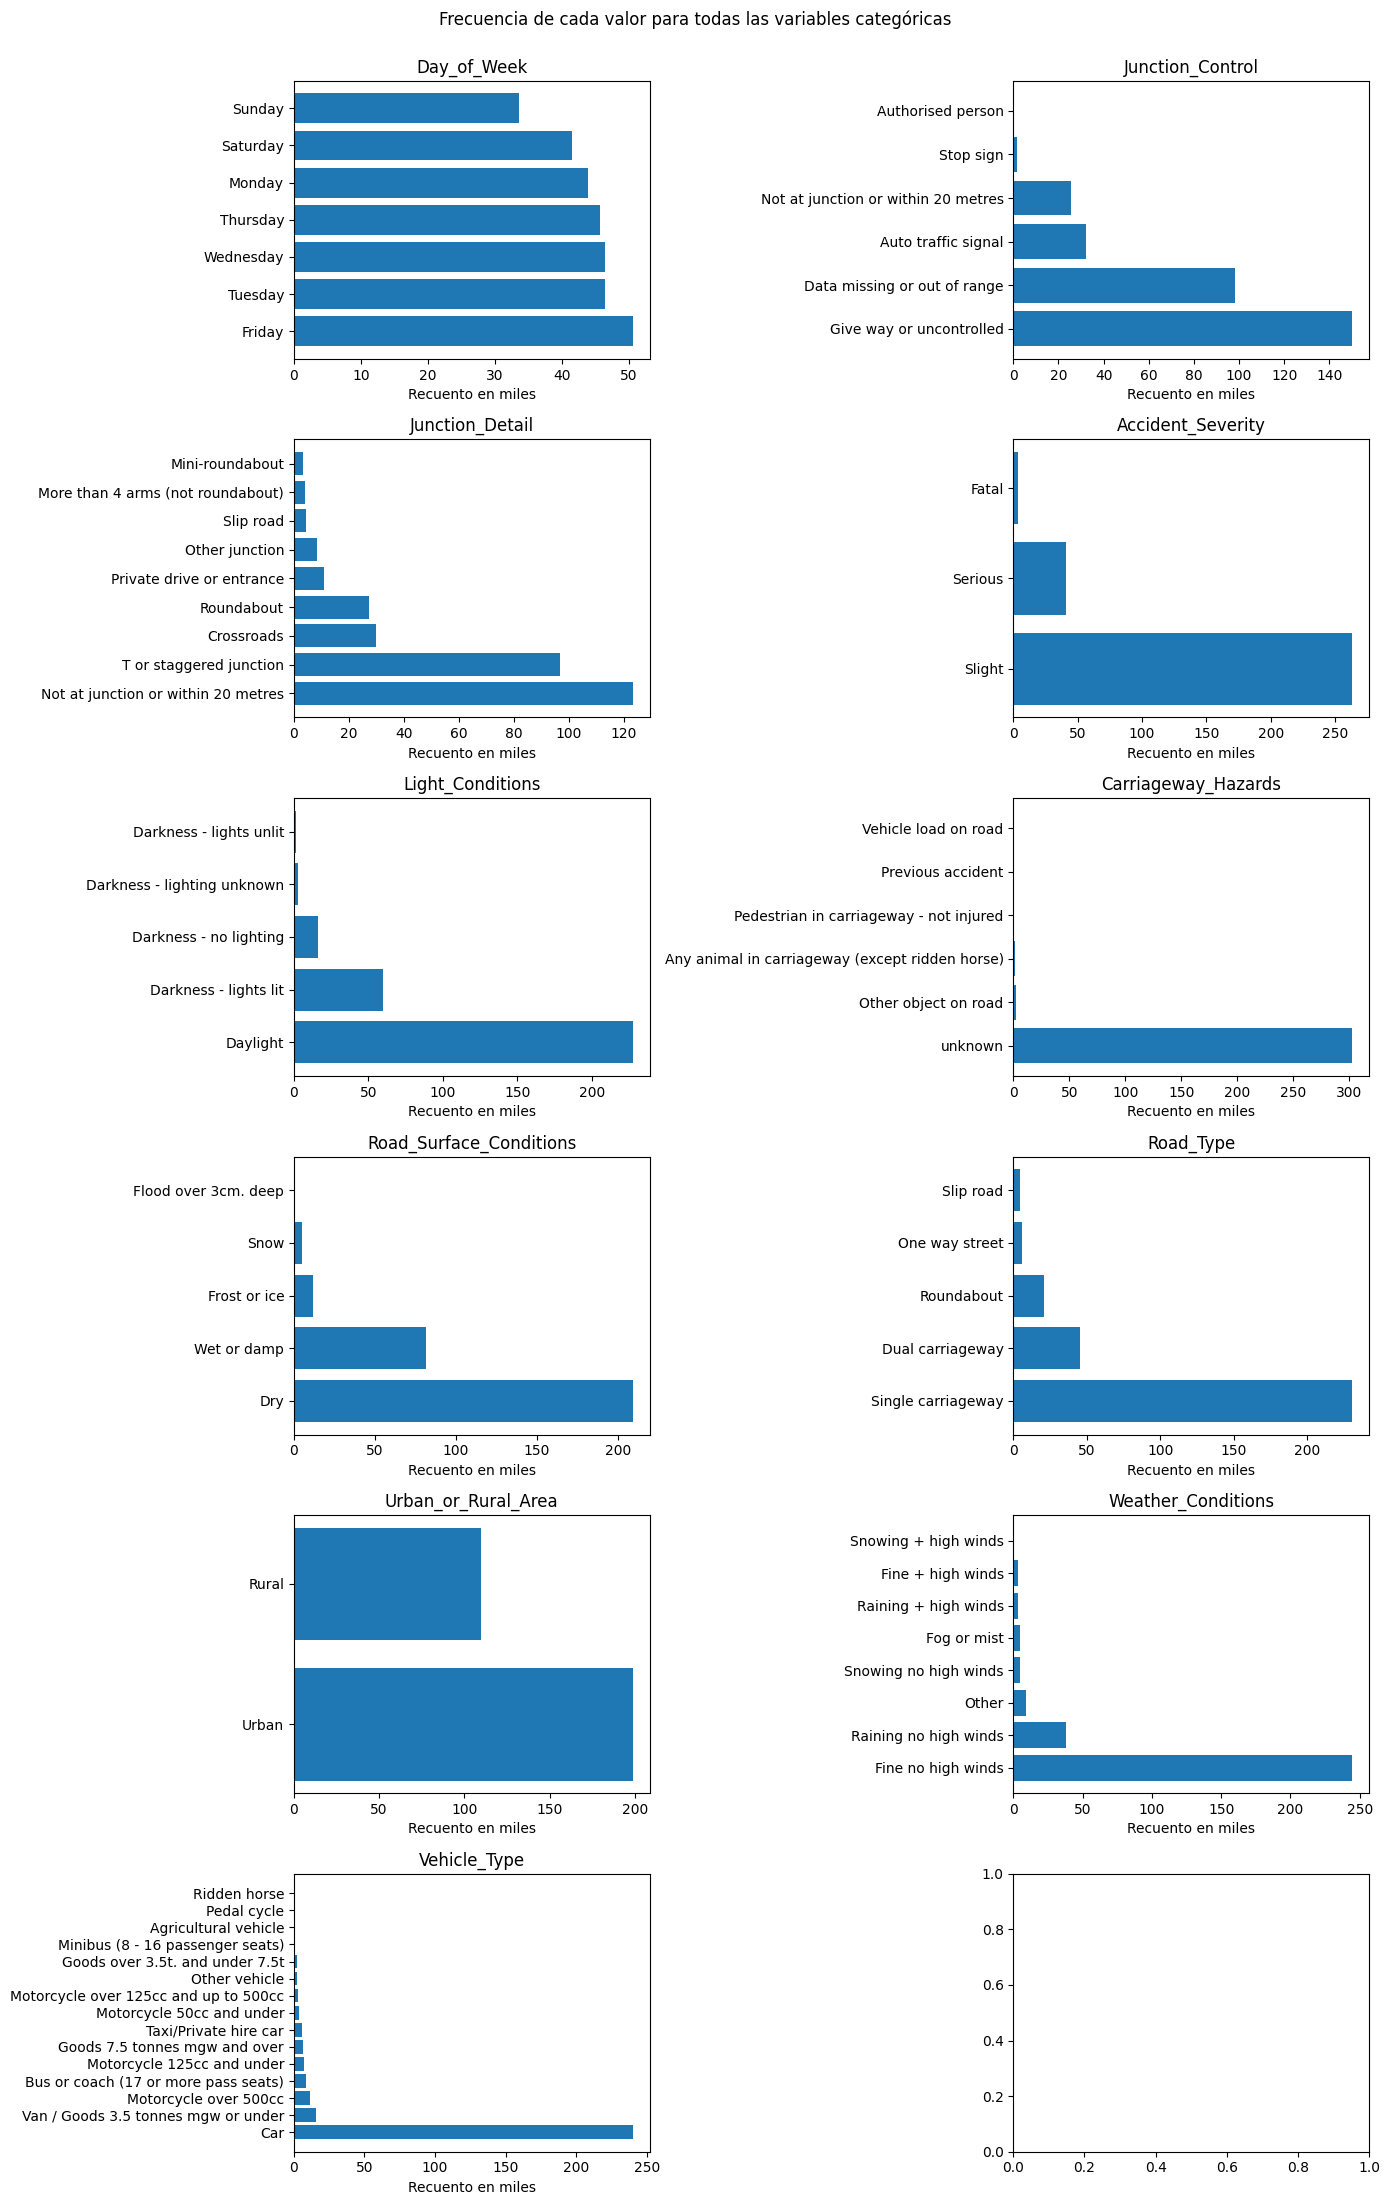

In [27]:
# Representamos en diagramas de barras los que tienen menos de 15 valores únicos

# Para cambiar el formato del eje
from matplotlib.ticker import FuncFormatter 

# Filtramos el diccionario
categorical_variables_unique_values_low_count = { 
    var: count 
    for var, count in categorical_variables_unique_values.items() 
    if count <= 15 
}

# Representación con plt.subplots
n = len(categorical_variables_unique_values_low_count)
fig, axes = plt.subplots(nrows = (n + 1) // 2, ncols = 2, figsize = (14, 2 * n))

for i, var in enumerate(categorical_variables_unique_values_low_count.keys()):
    ax = axes[i // 2, i % 2]
    counts = accidents[var].value_counts()
    ax.barh(counts.index.astype(str), counts.values)
    ax.set_title(var)
    ax.set_xlabel("Recuento en miles")

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1000:.0f}'))


plt.suptitle("Frecuencia de cada valor para todas las variables categóricas", y = 1)
plt.tight_layout()
plt.show()

A partir de estos gráficos, hemos identificado las siguientes dos erratas:

- En la variable ``Junction_Control``: 'Auto traffic sigl' en vez de 'Auto traffic signal'
- En la variable ``Accident_Severity``: 'Fetal' en vez de 'Fatal'

Procedemos a corregirlos:

In [10]:
# Reemplazar los valores incorrectos
accidents["Junction_Control"] = accidents["Junction_Control"].replace({ "Auto traffic sigl": "Auto traffic signal" })
accidents["Accident_Severity"] = accidents["Accident_Severity"].replace({ "Fetal": "Fatal" })

Ahora seguimos explorando el resto de variables categóricas, que son las siguientes:

In [11]:
# Filtramos el diccionario
categorical_variables_high_count = [ 
    var
    for var, count in categorical_variables_unique_values.items() 
    if count > 15 
]
print(categorical_variables_high_count)

['Accident_Index', 'Accident Date', 'Local_Authority_(District)', 'Police_Force', 'Time']


Podemos verficar si hay errores en las variables de índice, fecha y hora comprobando si se ajustan respectivamente a los siguientes expresiones regulares: 

1. ^[A-Z][A-Z][0-9]{7}\$
2. ^[0-3][0-9]-[0-1][0-9]-[0-9]{4}\$
3. ^[0-2][0-9]:[0-5][0-9]^\$

Esto verifica únicamente la sintaxis, por lo que solo es una comprobación superficial. En el caso de la fecha y hora, podremos verificar que su semántica es correcta cuando las convirtamos en una variable de marca de tiempo, en la Subsección 2.4.

In [12]:
# Índice
assert(all(accidents["Accident_Index"].str.match(r"^[A-Z]{2}\d{7}$")))

# Fecha
assert(all(accidents["Accident Date"].str.match(r"^[0-3][0-9]-[0-1][0-9]-\d{4}$")))

# Hora
assert(all(accidents["Time"].str.match(r"^[0-2][0-9]:[0-5][0-9]$")))

Todos los valores son correctos, por lo que seguimos con las variables restantes. 

Para intentar encontrar posibles errores en las variables relacionadas con los municipios, a saber, ``Local_Authority_(District)`` y ``Police_Force``, vamos a intentar fijarnos en los valores menos frecuentes. Para ellos, vamos a calcular la distancia de edición (Damerau-Levenshtein) con todo el resto de posibles valores para identificar si se corresponde a alguna posible errata, mostraremos solo por pantalla aquellos que tengan alguna otro valor bastante cercano.

In [13]:
def edit_distance(string: str, compare_to: set[str]) -> pd.Series:
    """ 
    Calcula la distancia de edición de una cadena de texto con todas las del 
    conjunto `compare_to``. Devuelve una pd.Series donde el índice es la cadena
    con la que se ha comparado, y el valor la distancia Damerau-Levenshtein.
    """
    compare_to = list(compare_to)
    return pd.Series(
        np.vectorize(lambda s: textdistance.damerau_levenshtein.distance(string, s))(compare_to),
        index = compare_to
    )

def identify_similar_strings(
        variable: pd.Series, 
        number_of_least_frequent_to_analyse: int = 50,
        min_distance_cutoff: int = 3
    ) -> None:
    """
    Compara los `number_of_least_frequent_to_analyse` elementos menos frecuentes de 
    la pd.Series `variable`, con el resto de cadenas de texto. Esto permite comprobar
    si ha habido alguna errata en los datos. Imprime la cadena más cercana por pantalla,
    en caso de que su distancia sea menor o igual que `min_distance_cutoff`.
    """
    value_counts = variable.value_counts()
    unique_set = set(value_counts.index)

    print(f"{'Valor':<25} -- {'Recuento':^10} -- {'Valor más cercano':^25} -- {'Distancia':^10}")
    for value, value_count in value_counts[-number_of_least_frequent_to_analyse:][::-1].items():
        distances = edit_distance(value, unique_set.difference({ value }))
        min_distance = distances.min()
        if min_distance > min_distance_cutoff:
            continue
        print(f"{value:<25} -- {value_count:^10_} -- {distances.idxmin():^25} -- {min_distance:^10}")
    


print("Distritos"); identify_similar_strings(accidents["Local_Authority_(District)"])
print("\nPolicías"); identify_similar_strings(accidents["Police_Force"])

Distritos
Valor                     --  Recuento  --     Valor más cercano     -- Distancia 
Teesdale                  --     15     --         Tynedale          --     3     
South Shropshire          --     18     --     North Shropshire      --     2     
Alnwick                   --     20     --          Warwick          --     3     
Clackmannanshire          --     25     --      Clackmannshire       --     2     
North Shropshire          --     32     --     South Shropshire      --     2     
Tynedale                  --     35     --          Ryedale          --     2     
Wear Valley               --     36     --        Test Valley        --     3     
Kennet                    --     39     --          Barnet           --     3     
Caradon                   --     44     --          Maldon           --     3     
Crewe and Nantwich        --     49     --     Crewe and ntwich      --     2     
Clackmannshire            --     52     --     Clackmannanshire      --     2

Para la variable de los distritos, hemos encontrado los siguientes errores buscando en google los más sospechosos, y comprobando que efectivamente son errores:

| Correcto             | Incorrecto           |
|----------------------|----------------------|
| Clackmannanshire     | Clackmannshire       |
| Crewe and Nantwich   | Crewe and ntwich     |
| Blaenau Gwent        | Blaeu Gwent          |
| Stevenage            | Stevege              |

Como esta ha sido una búsqueda no exhaustiva, y hemos encontrado bastantes errores que además se repiten con bastante frecuencia, es probable que pudiéramos encontrar más de querer seguir buscando.

Corregimos los errores encontrados:

In [14]:
# Reemplazar los valores incorrectos
accidents["Local_Authority_(District)"] = accidents["Local_Authority_(District)"].replace({
    "Clackmannshire": "Clackmannanshire",
    "Crewe and ntwich": "Crewe and Nantwich",
    "Blaeu Gwent": "Blaenau Gwent",
    "Stevege": "Stevenage"
})

## 2.3. Corrección de errores en variables numéricas

En esta subsección intentamos verificar que no haya errores en las variables numéricas. Para identificarlos un criterio podría ser buscar datos que se salgan de un rango razonable. Un ejemplo podría ser número de victimas negativo, o algo similar. En cierta manera estaríamos buscando atípicos, aunque desde una perspectiva estrictamente de corrección semántica. Para buscar estos atípicos haremos dos visualizaciones, una matriz de gráficos planos y gráficos de cajas y bigotes (*boxplot*) para las variables numéricas.

In [ ]:
# Lista de variables numéricas
numerical_variables: list[str] = [
    var
    for var in accidents.columns 
    if accidents[var].dtype != "object" 
]
print(numerical_variables)

['Latitude', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit']


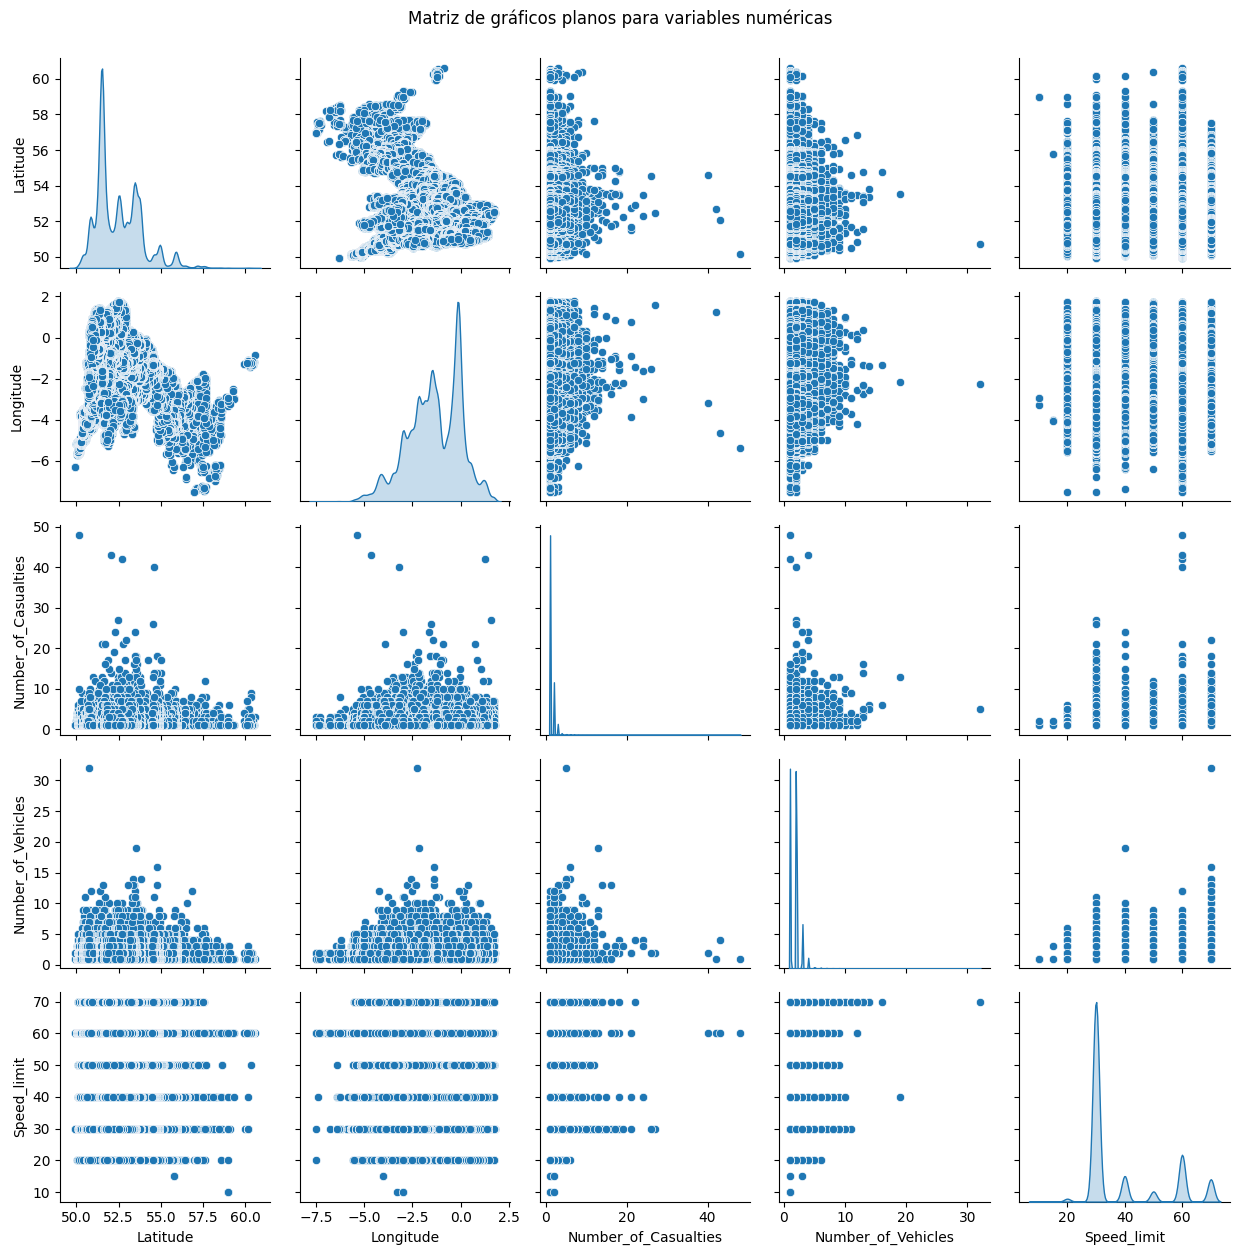

In [46]:
# Matriz de gráficos planos
sns.pairplot(accidents[numerical_variables], diag_kind = "kde")

plt.suptitle("Matriz de gráficos planos para variables numéricas", y = 1)
plt.tight_layout()
plt.show()

A la vista de este gráfico, no parece haber ningún problema de errores en los datos. Algunas otras conclusiones que podemos sacar es que en el gráfico de latitud vs longitud podemos ver perfectamente el mapa de Gran Bretaña (sin irlanda del norte), y que la mayoría de los datos se concentran geográficamente en el centro del país, más en especídfico en el entorno de Londres, que presenta un pico en la frecuencia. Las dos variables que posiblemente den más problema con los atípicos sean las de número de víctimas y número de vehículos, que son muy asimétricas a la derecha. No obstante, no parece que contengan errores.

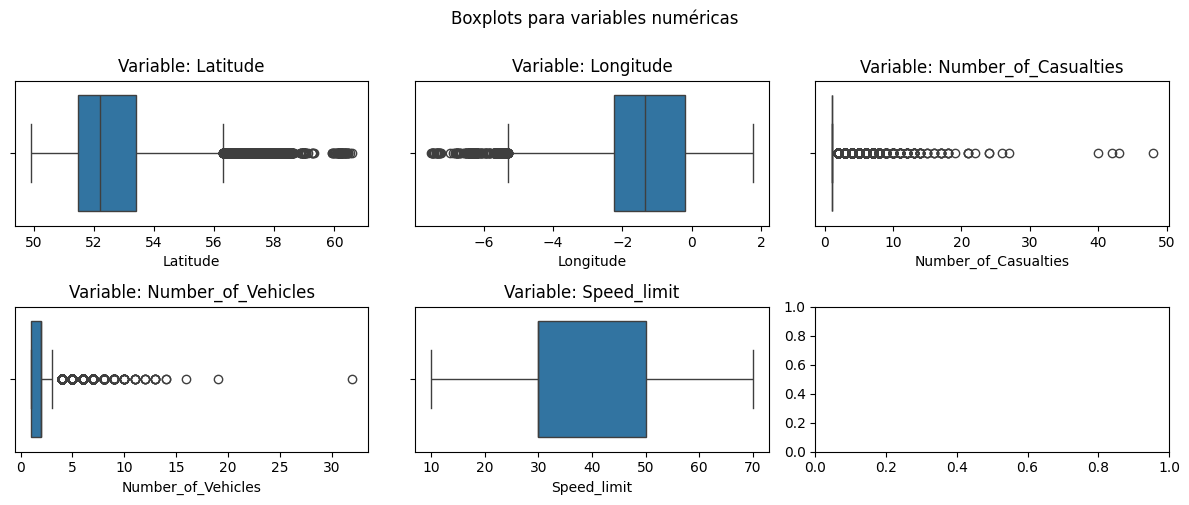

In [42]:
# Boxplots para variables numéricas

n = len(numerical_variables)
fig, axes = plt.subplots(nrows = (n + 2) // 3, ncols = 3, figsize = (12, n))

for i, var in enumerate(numerical_variables):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x = accidents[var], ax = ax)
    ax.set_title(f"Variable: {var}")

plt.suptitle("Boxplots para variables numéricas", y = 1)
plt.tight_layout()
plt.show()

A partir de estos gráficos podemos confirmar las conclusiones del gráfico anterior, viendo como la mayoría de los datos se concentran en el centro del país, siendo las latitudes muy al norte y las longitudes muy hacia el oeste poco frecuentes. Las variables de número de víctimas y número de vehículos son muy asimétricas mientras que la variable de límite de velocidad está razonablemente bien distribuida, ya que su rango de valores es limitado.

## 2.4. Tranformaciones

In [94]:
# Crear variable de marca de tiempo
accidents["timestamp"] = pd.to_datetime(accidents["Accident Date"] + ' ' + accidents["Time"], format = "%d-%m-%Y %H:%M")

# Rango temporal de los accidentes del dataset
print(f"Rango temporal:{accidents['timestamp'].min(): %B %d, %Y %H:%M} <-->" + \
      f"{accidents['timestamp'].max(): %B %d, %Y %H:%M}")

Rango temporal: January 01, 2021 00:01 <--> December 31, 2022 23:30


# 3. Análisis exploratorio

## 3.x. Atípicos

En esta subsección exploramos los atípicos ...

Los atípicos no son malos *per se*, pero con este análisis vamos a poder identificar posibles errores en los datos, en caso de que los haya, o simplemente identificar posibles puntos de influencia para los análisis posteriores.

# 4. Estimación de factores de riesgo

De accidentes graves en comparación con accidentes leves


## 4.1. Metodología

Transformaciones, modelo, etc


## 4.2. Ajuste


## 4.3. Validación


## 4.4. Conclusiones

# 5. Comparativa de riesgo entre regiones



## 5.1. Metodología

## 5.2. Ajuste

## 5.3. Validación

## 5.4. Conclusiones

# 6. Conclusiones